# Dask Machine Learning Workflows on the Midway Cluster

In this notebook, we are going to focus on two things:

1. Learning how to run interactive Dask jobs on the Midway Cluster.
2. Exploring Dask's machine learning functionality and its capacity to plug into existing scikit-learn workflows.

To accomplish these goals, we will work with the Amazon Customer Reviews Dataset that is available here on Midway in the `/project/macs30123/` directory.

To run this notebook, you should log in to the Midway Cluster [via ThinLinc](https://midway3.rcc.uchicago.edu/main/). After you're logged in, run the following lines of code in a terminal window from a login node (to load the Python module we've been working with in the class and then install a couple of additional packages we'll be using):

```
module load python
pip install --user dask[complete]==2022.7.0 dask-jobqueue==0.7.4 dask-ml==2022.5.27
pip install --user --force-reinstall --upgrade jupyter
```

Once you have installed these packages, start up a Jupyter Lab from the login node (you'll be requesting resources via `dask-jobqueue`'s `SLURMCluster` class within this notebook):

```
jupyter lab
```

-----

*Credits: Thank you to [Yutao Chen](https://github.com/cytwill), who wrote the first version of this notebook (Fall 2020).*

## Launching a Dask Cluster via SLURM

To request Midway Cluster resources for our Dask Cluster, we have installed [dask-jobqueue](https://jobqueue.dask.org/en/latest/), which can be used to deploy Dask via common job queuing systems like SLURM (used in the Midway Cluster). Furthermore, it allows us to perform these interactions with SLURM an interactive context within a Jupyter Notebook.

Specifically, we'll be using the SLURMCluster function to request resources, using many of the same key words that we provide when write an `sbatch` script or provide arguments for `sinteractive` jobs. For instance, here, we're requesting 10 `caslake` cores with 40GB of memory that are connected via an `ib0` (InfiniBand) interconnect (which we'll have available to us for 1 hour):

In [1]:
from dask_jobqueue import SLURMCluster

# Compose SLURM script
cluster = SLURMCluster(queue='caslake', cores=10, memory='40GB', 
                       processes=10, walltime='01:00:00', interface='ib0',
                       job_extra=['--account=macs30123']
                      )

# Request resources
cluster.scale(jobs=1)

We'll need to wait a bit for our resources to be provisioned, but we can check on the progress of our resources via `squeue` as usual:

In [2]:
! squeue -u jclindaniel

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          20013295   caslake dask-wor jclindan  R       0:05      1 midway3-0010


Once our resources have been provisioned, we need to tell Dask that it should use them to run its computations. We can do this, by passing `cluster` into our `dask.distributed` client object.

In [3]:
from dask.distributed import Client

client = Client(cluster)
client

<Client: 'tcp://172.25.0.65:33285' processes=10 threads=10, memory=37.30 GiB>

That's all we need to do! If we want to see an interactive representation of what our workers are doing at any given time, we can click the link above, as in all the other Dask setups. 

We're now ready to start using Dask. Let's start by reading our Customer Reviews Data (~17 GB in CSV form) into a Dask DataFrame:

In [4]:
import dask.dataframe as dd

df = dd.read_csv('/project/macs30123/AWS_book_reviews/*.csv')

In [5]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012
2,US,52925878,R10SRJA4VVGUBD,055341805X,846590203,Hyacinth Girls: A Novel,4,0,0,Y,N,Mysteries upon mysteries,"Rebecca, a dental hygienist, receives a call a...",2015-05-02,2015
3,US,40062567,RD3268X41GM7U,0425263908,119148606,Bared to You,5,1,1,N,N,"""RAW, STEAMY, HYPNOTIC!""","\\""BARED TO YOU\\"" is a sizzling, red-hot pass...",2012-06-29,2012
4,US,47221489,R3KGQL5X5BSJE1,1416556141,987400385,Healer: A Novel,5,0,0,N,Y,Well written story,Good characters and plot line. I spent a pleas...,2015-05-02,2015


In [6]:
df.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
year                  int64
dtype: object

Note that if we look at the shape of the DataFrame, we can't actually see the number of rows immediately -- this is a `delayed` object that is only computed if we call the `.compute()` method. We need to do the same in order to describe our DataFrame as whole. Recall that, under the hood, Dask constructs an optimal task graph and only executes this series of tasks when we call the `.compute()` method:

In [7]:
df.shape

(Delayed('int-c947e3bf-fd71-4d4c-a343-51e1a452d565'), 15)

In [8]:
df.shape[0].compute()

20726160

In [9]:
df.describe().compute()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,year
count,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07,2.072616e+07
mean,3.287233e+07,5.012232e+08,4.340540e+00,3.836475e+00,5.332147e+00,2.010451e+03
std,1.545060e+07,2.878609e+08,1.125604e+00,2.240867e+01,2.581018e+01,4.506381e+00
min,1.002400e+04,5.760000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.995000e+03
25%,2.868947e+07,2.647167e+08,4.000000e+00,0.000000e+00,1.000000e+00,2.010000e+03
50%,4.311779e+07,5.123202e+08,5.000000e+00,1.000000e+00,2.000000e+00,2.013000e+03
75%,5.246832e+07,7.581745e+08,5.000000e+00,7.000000e+00,9.000000e+00,2.014000e+03
max,5.309659e+07,9.999999e+08,5.000000e+00,2.755000e+04,2.872700e+04,2.015000e+03


### Preprocessing

Next, let's perform some basic preprocessing for the book review dataset to obtain features for our machine learning demonstration later on. Intuitively, ID-like attributes are not likely to provide much useful information. Other attributes like total_votes and helpful_votes might contain more useful information about the ratings of books. We can make a mean calculation based on the groupby results to check our assumptions (here, across several different marketplaces):

In [10]:
df.groupby(by='marketplace') \
  .mean() \
  .compute()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,year
marketplace,,,,,,
DE,4.196011e+07,5.047194e+08,4.358941,2.360758,3.647635,2005.886768
FR,3.075995e+07,5.214875e+08,4.308173,2.785668,3.946417,2011.635635
JP,3.667752e+07,5.157488e+08,4.452929,6.054778,8.073038,2009.791874
UK,3.263059e+07,5.065183e+08,4.363765,2.979392,4.290699,2012.018752
US,3.284676e+07,5.011147e+08,4.340153,3.851688,5.350379,2010.444432


Not all of our data is numerical, though. We might want to encode categorial variables -- for instance, whether a user is a "Vine" member, or is a verified purchaser. These are both binary categories, so we'll just assign yes to "1" and no "0."

In [11]:
df['vine_code'] = df['vine'].apply(lambda x:1 if x=='Y' else 0, 
                                   meta=('vine', 'int64'))
df['verified_purchase_code'] = df['verified_purchase'].apply(lambda x:1 if x=='Y' else 0,
                                                             meta=('verified_purchase', 'int64'))

In [12]:
df[['vine_code','verified_purchase_code']].head()

,vine_code,verified_purchase_code
0,0,1
1,0,0
2,1,0
3,0,0
4,0,1


We can also construct new columns in our DataFrame, derived from existing columns. To cast this as a binary classification problem, let's create a column based on "Star Rating" that assigns any rating greater than 3 as a "good" review and any rating less than that as a "bad" one. We'll call this column `label`, as it will be the label we try to predict when fit our classifier later on:

In [13]:
df['label'] = df['star_rating'].apply(lambda x: 1 if x > 3 else 0, 
                                      meta=('star_rating', 'int64'))
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,vine_code,verified_purchase_code,label
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015,0,1,1
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012,0,0,1
2,US,52925878,R10SRJA4VVGUBD,055341805X,846590203,Hyacinth Girls: A Novel,4,0,0,Y,N,Mysteries upon mysteries,"Rebecca, a dental hygienist, receives a call a...",2015-05-02,2015,1,0,1
3,US,40062567,RD3268X41GM7U,0425263908,119148606,Bared to You,5,1,1,N,N,"""RAW, STEAMY, HYPNOTIC!""","\\""BARED TO YOU\\"" is a sizzling, red-hot pass...",2012-06-29,2012,0,0,1
4,US,47221489,R3KGQL5X5BSJE1,1416556141,987400385,Healer: A Novel,5,0,0,N,Y,Well written story,Good characters and plot line. I spent a pleas...,2015-05-02,2015,0,1,1


In [14]:
df.groupby('label').count().compute()['star_rating'] # not balanced

label
0     3517710
1    17208450
Name: star_rating, dtype: int64

OK, so we have some features and we have a label that we want to use them to predict (e.g. will a review be "bad" or "good?"). Let's arbitrarily pick some of these features and proceed with fitting our model:

In [15]:
num_feature_df = df[['helpful_votes','total_votes','vine_code','verified_purchase_code']]

Finally, before we fit our model, let's scale our data to decrease the effect of different scales for different attributes (for different scale methods, see [here](https://ml.dask.org/modules/api.html#module-dask_ml.preprocessing)):

In [16]:
from dask_ml.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_feature_df = scaler.fit_transform(num_feature_df)
num_feature_df.head()

,helpful_votes,total_votes,vine_code,verified_purchase_code
0,0.000327,0.000348,0.0,1.0
1,0.000145,0.000244,0.0,0.0
2,0.000000,0.000000,1.0,0.0
3,0.000036,0.000035,0.0,0.0
4,0.000000,0.000000,0.0,1.0


And we'll compute the overall size (and chunk size) of our datasets, so we can best decide how many samples we need for training and test data sets. Otherwise, we would not know the total sample size of our feature and label arrays (since they're distributed over multiple workers):

In [17]:
import dask.array

label_array = df['label'].to_dask_array() \
                         .compute_chunk_sizes()

num_feature_array = num_feature_df.to_dask_array() \
                                  .compute_chunk_sizes()


### Machine Learning

Now that we know the size of our data (and how much of it is on different workers), we can split up our data into training and testing sets:

In [18]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(num_feature_array, 
                                            label_array,
                                            train_size=0.7,test_size=0.3,
                                            random_state=0)

In [19]:
X_train

dask.array<concatenate, shape=(14508188, 4), dtype=float64, chunksize=(92138, 4), chunktype=numpy.ndarray>

In [20]:
y_test

dask.array<concatenate, shape=(6217967,), dtype=int64, chunksize=(39489,), chunktype=numpy.ndarray>

And let's recompute our class counts for our labels ("good" and "bad") so that we can use this to weight our classes in our classifier and try to deal with some of the class imbalance:

In [21]:
class_counts = df.groupby('label') \
                 .count() \
                 .compute()['star_rating']
               

Let's say that we wanted to fit a classifier to predict these labels based on our features using stochastic gradient descent (SGD). We might turn to Scikit-learn's [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) for this task, which fits a classifier using the stochastic gradient descent method via several different loss functions, different penalties and so on.

Performing a search over this hyperparameter space would normally be challenging given the size of our data, but Dask conveniently allows us to perform such searches by providing a Scikit-learn classifier object to one of its "Search" functions. So, that's great! all we need to do is write a Scikit-learn classifier and Dask will automatically handle the parallelization of the hyperparameter search for us. Note that Dask-ML supports a similar workflow for Deep Learning packages like [PyTorch](https://ml.dask.org/pytorch.html), [Keras, and TensorFlow](https://ml.dask.org/keras.html).

To perform our hyperparameter search here, let's use an [incremental search](https://ml.dask.org/modules/generated/dask_ml.model_selection.IncrementalSearchCV.html):

In [24]:
from dask_ml.model_selection import IncrementalSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

clf = SGDClassifier(class_weight={0: 1, 1: class_counts[0] / class_counts[1]})
params = {'alpha': np.logspace(-4, 0, num=1000),
          'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
          'average': [True, False]}

search = IncrementalSearchCV(clf, params, decay_rate=None)
search.fit(X_train, y_train, classes=[0,1])

IncrementalSearchCV(decay_rate=None,
                    estimator=SGDClassifier(class_weight={0: 1,
                                                          1: 0.20441759716883276}),
                    parameters={'alpha': array([1.00000000e-04, 1.00926219e-04, 1.01861017e-04, 1.02804473e-04,
       1.03756668e-04, 1.04717682e-04, 1.05687597e-04, 1.06666496e-04,
       1.07654461e-04, 1.08651577e-04, 1.09657929e-04, 1.10673602e-04,
       1.11698682e-04, 1.12733256e-04, 1.13777413e...
       8.39312950e-01, 8.47086827e-01, 8.54932707e-01, 8.62851257e-01,
       8.70843150e-01, 8.78909065e-01, 8.87049689e-01, 8.95265713e-01,
       9.03557835e-01, 9.11926760e-01, 9.20373200e-01, 9.28897872e-01,
       9.37501502e-01, 9.46184819e-01, 9.54948564e-01, 9.63793480e-01,
       9.72720319e-01, 9.81729841e-01, 9.90822810e-01, 1.00000000e+00]),
                                'average': [True, False],
                                'loss': ['hinge', 'log_loss', 'modified_huber',
                                         'squared_hinge']})

In [25]:
# check the best parameter
search.best_estimator_

SGDClassifier(alpha=0.4361537789208006,
              class_weight={0: 1, 1: 0.20441759716883276}, loss='log_loss')

In [26]:
# check the train accuracy
search.best_score_

0.8305487487933467

In [27]:
# check the test accuracy
search.best_estimator_.score(X_test,y_test)

0.8301534890744837

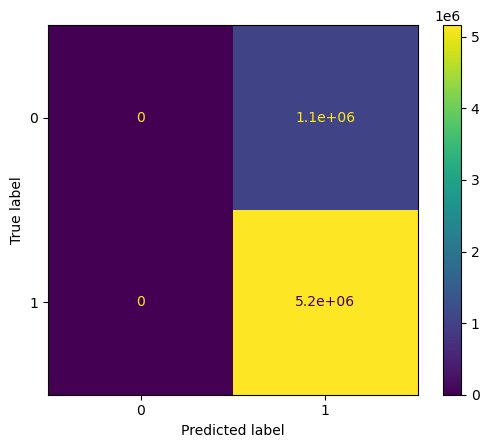

In [30]:
%matplotlib inline
# plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = search.best_estimator_.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

This model suffers a lot from data imbalance even after we specified weights (we're just predicting "Good" reviews regardless of what the true label is). Remember, though, we performed relatively naive feature selection here and could engineer better features with a bit more work.

Regardless, from this short demo, you can see how seamless it is to perform Pandas DataFrame-like operations as well as Scikit-Learn machine learning tasks in Dask. If you're already working with these libraries in other capacities, this can be a great way to scale out your code, with very little additional effort on your part (e.g. writing new code in PySpark)!